In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
matplotlib.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10, 7)

from sklearn.metrics import mean_squared_error

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
# 19-state takes quite a while to compute, so use 9 instead
NUM_STATES = 9
STATES = np.arange(1, NUM_STATES + 1)
# STATE id happens to be the same as the true denormalized state value.
V_TRUE = STATES / (NUM_STATES + 1)

# Add 2 exit state, the state after exit actoin, whose state value will be 0
EXIT_STATES = [0, NUM_STATES + 1]

NUM_ALL_STATES = NUM_STATES + len(EXIT_STATES)

STARTING_STATE = (NUM_STATES + 1) / 2 + 1 # set starting state to the middle; +1 offset the first exit state

print(STATES)
print(V_TRUE)
print('starting at State: {0}'.format(int(STARTING_STATE)))

[1 2 3 4 5 6 7 8 9]
[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
starting at State: 6


In [3]:
def is_exit_state(state):
    return state in EXIT_STATES

In [4]:
def is_reward_exit_state(state):
    return state == EXIT_STATES[-1]

In [5]:
def take_action(s0):
    rand = np.random.random()
    if rand >= 0.5:
        s1 = s0 - 1
    else:
        s1 = s0 + 1

    if is_reward_exit_state(s1):
        reward = 1
    else:
        reward = 0
    return s1, reward

calc_target implements Eq. (7.1) in the Sutton and Barto textbook
$G_{t}^{(n)} = R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} + ... + \gamma^{n-1} R_{t+n} + \gamma ^{n} V(S_{t+n})$

In [14]:
def calc_target(v_func, s0, gamma, n_step):
    #READ THE ALGORITHM CAREFULLY AND INSERT THE CODE    
    """"
    Step 1: Initialize the assertions to ensure that n_step is at least 1 and gamma is within the range (0, 1].

    Step 2: Initialize target = 0 to store the cumulative reward.

    Step 3: Start a loop that runs for n_step iterations.

    Step 4: Within the loop, take an action from state s0 to obtain the next state s1 and the received reward reward_i.

    Step 5: Update the target by adding the discounted reward using the formula:
    target += (gamma ** i * reward_i).

    Step 6: Update s0 = s1 to move to the next state.

    Step 7: If i == 0, store s_prime = s1 to track the immediate next state.

    Step 8: If s1 is an exit state, break the loop.

    Step 9: Clip s1 within the valid range [0, len(v_func) - 1] to ensure it remains within bounds.

    Step 10: Compute the final target value by adding the discounted value function estimate for s1 using the formula:
    target += gamma ** n_step * v_func[s1].

    Step 11: Return s_prime as the immediate next state and target as the computed value."""
    # Step 1: Initialize assertions
    assert n_step >= 1, "n_step must be at least 1"
    assert 0 < gamma <= 1, "gamma must be in (0, 1]"
    
    # Step 2: Initialize target to store cumulative reward
    target = 0
    
    # Step 3-8: Run n-step iterations to accumulate discounted rewards
    s_prime = None
    for i in range(n_step):
        # Step 4: Take action from state s0
        s1, reward_i = take_action(s0)
        
        # Step 5: Update target with discounted reward
        target += (gamma ** i) * reward_i
        
        # Step 7: Store immediate next state if first iteration
        if i == 0:
            s_prime = s1
        
        # Step 6: Update state for next iteration
        s0 = s1
        
        # Step 8: Break if reached an exit state
        if is_exit_state(s1):
            break
    
    # Step 9: Ensure s1 is within valid range AND convert to integer
    s1 = int(max(0, min(s1, len(v_func) - 1)))
    
    # Step 10: Add discounted value function estimate if not at exit state
    if not is_exit_state(s1):
        target += (gamma ** n_step) * v_func[s1]
    
    # Step 11: Return immediate next state and target value
    return s_prime, target

$\Delta V_{t}(S_{t}) = \alpha [G_{t}^{(n)} - V_{t}(S_{t})]$

In [15]:
def run_a_episode(v_func, s0=STARTING_STATE, alpha=0.1, gamma=1, n_step=1):
    #READ THE ALGORITHM CAREFULLY AND INSERT THE CODE   
    """Step 1: Start an infinite loop using while True.

    Step 2: Call the calc_target function with parameters v_func, s0, gamma, n_step to compute the next state s1 and the corresponding target value.

    Step 3: Convert s0 to an integer before using it as an index to ensure compatibility with v_func.

    Step 4: Update the value function using the update rule:
    v_func[int(s0)] = v_func[int(s0)] + alpha * (target - v_func[int(s0)]).

    Step 5: Set s0 = s1 to move to the next state.

    Step 6: Check if s1 is in the set of exit states (EXIT_STATES). If true, break the loop and stop execution."""

    # Step 1: Start infinite loop for the episode
    while True:
        # Step 2: Calculate target using n-step TD
        s1, target = calc_target(v_func, s0, gamma, n_step)
        
        # Step 3-4: Update value function using TD update rule
        v_func[int(s0)] = v_func[int(s0)] + alpha * (target - v_func[int(s0)])
        
        # Step 5: Move to next state
        s0 = s1
        
        # Step 6: Break loop if reached exit state
        if is_exit_state(s1):
            break
            
    return v_func

In [16]:
def init_v_func(num_all_states):
    """initialize value function"""
    v_func = np.repeat(0.5, NUM_ALL_STATES)
    # The value of EXIT_STATES should be 0
    v_func[0], v_func[-1] = 0, 0
    return v_func

In [17]:
# mse of the inital value function and true value function
print(mean_squared_error(init_v_func(NUM_ALL_STATES)[1:-1], V_TRUE))

0.06666666666666668


In [18]:
alpha_list = [0.01, 0.02, 0.04, 0.08, 0.1, 0.16, 0.32, 0.4, 0.5, 0.64, 0.8, 1]
print('alpha_list: {0}'.format(alpha_list))
# n_step_list = [1000, 200, 100, 60, 30, 15, 8, 5, 2, 1]
n_step_list = [1000, 200, 100, 30, 8, 2, 1]
n_episodes = 10
n_experiments = 100

mse = np.zeros((n_experiments, len(alpha_list), len(n_step_list)))

alpha_list: [0.01, 0.02, 0.04, 0.08, 0.1, 0.16, 0.32, 0.4, 0.5, 0.64, 0.8, 1]


This cell takes the most time to run

In [19]:
for expi in range(n_experiments):
    if (expi + 1) % 20 == 0:
        print('working on Experiment {0}'.format(expi + 1))
    for i, alpha in enumerate(alpha_list):
#         print('working on alpha = {0}'.format(alpha))
        for j, n_step in enumerate(n_step_list):
    #         print('working on alpha = {0}, n_step = {1}'.format(alpha, n_step))
            v_func = init_v_func(NUM_ALL_STATES)
            for _ in range(n_episodes):
                v_func = run_a_episode(v_func, alpha=alpha, n_step=n_step)
            mse[expi, i, j] = mean_squared_error(V_TRUE, v_func[1:NUM_STATES + 1].flatten())

working on Experiment 20
working on Experiment 40
working on Experiment 60
working on Experiment 80
working on Experiment 100


In [20]:
rms = np.sqrt(mse)

In [21]:
rms.shape

(100, 12, 7)

In [22]:
rms_ave = rms.mean(axis=0)
rms_std = rms.std(axis=0)

(0.05, 0.26)

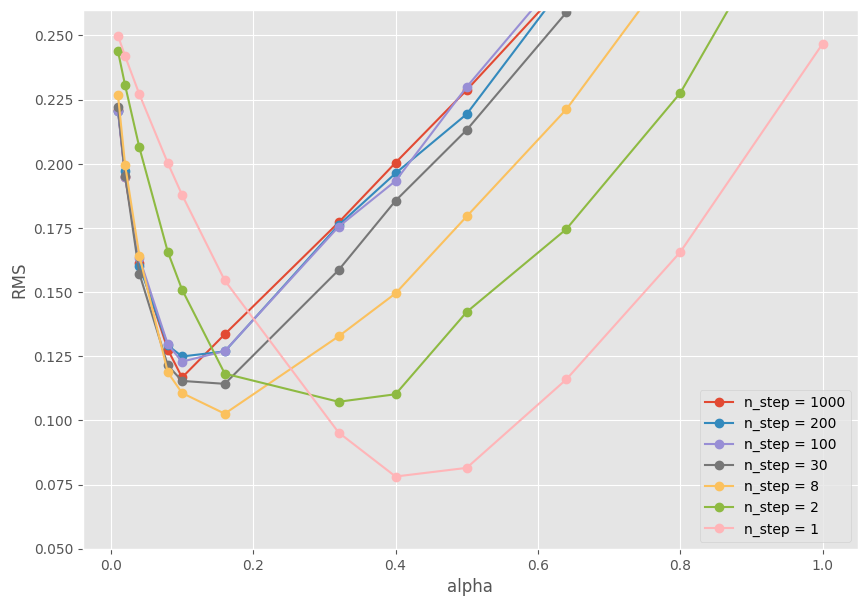

In [23]:
for i, n_step in enumerate(n_step_list):
    vals = rms_ave[:, i]
    std = rms_std[:, i]
    plt.plot(alpha_list, vals, 'o-', label='n_step = {0}'.format(n_step))

plt.legend(loc='best')
plt.xlabel('alpha')
plt.ylabel('RMS')
plt.ylim(0.05, 0.26)

**Note**: I didn't obtain the exact similar trend as Figure 7.2 for the on-line part. n_step=1 seems to be the best with alpha = 0.4. At least for this case.

#### without limited y axis

Text(0, 0.5, 'RMS')

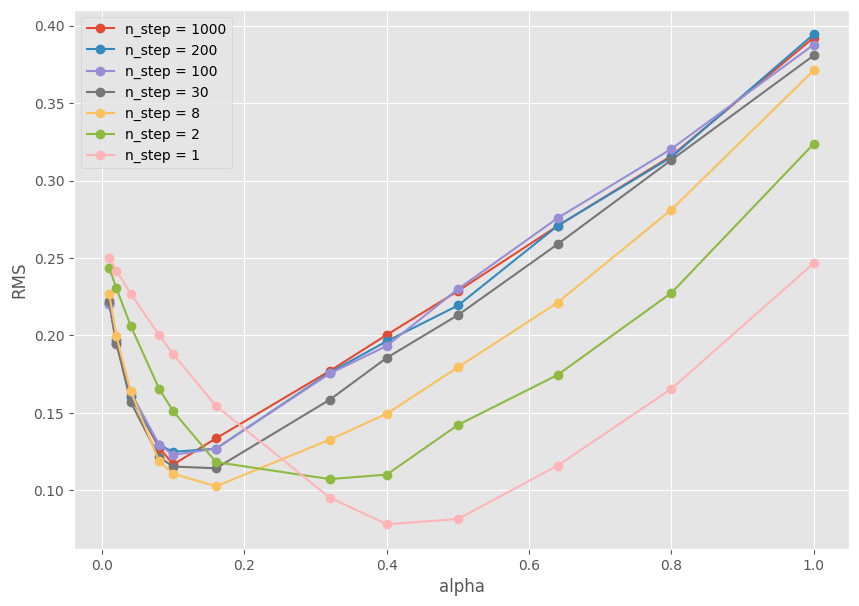

In [24]:
for i, n_step in enumerate(n_step_list):
    vals = rms_ave[:, i]
    std = rms_std[:, i]
    plt.plot(alpha_list, vals, 'o-', label='n_step = {0}'.format(n_step))

plt.legend(loc='best')
plt.xlabel('alpha')
plt.ylabel('RMS')

#### view separately for clarity

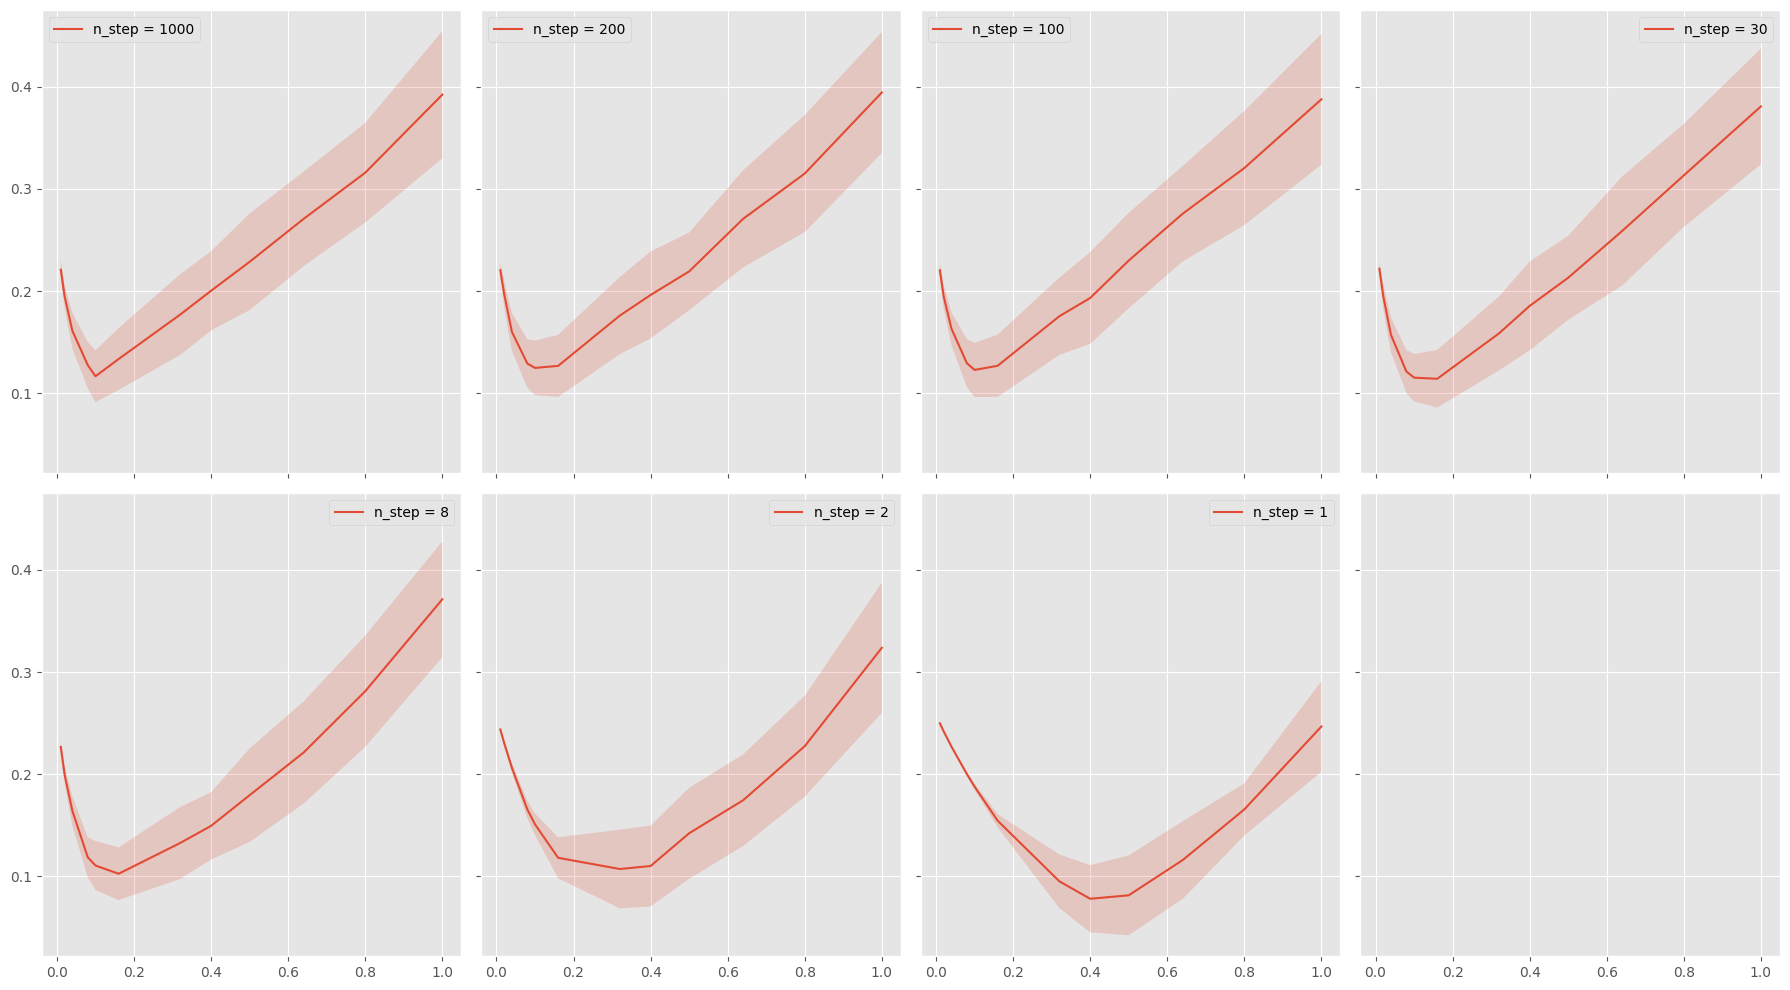

In [25]:
fig, axes = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(18, 10))
axes = axes.ravel()

for i, n_step in enumerate(n_step_list):
    ax = axes[i]
    vals = rms_ave[:, i]
    std = rms_std[:, i]
    ax.plot(alpha_list, vals, label='n_step = {0}'.format(n_step))
    ax.fill_between(alpha_list, vals - std, vals + std, alpha=0.2)
    ax.legend()

plt.tight_layout()

**Note**: When $\alpha$ increases, the error increases.

The following part is similar to random walk with TD(0), but you can play around by adjusting n_step

## See how it converges to true value function as the number of episodes increases

working on 0
working on 1
working on 10
working on 100
working on 500
working on 1000


Text(0, 0.5, 'Value')

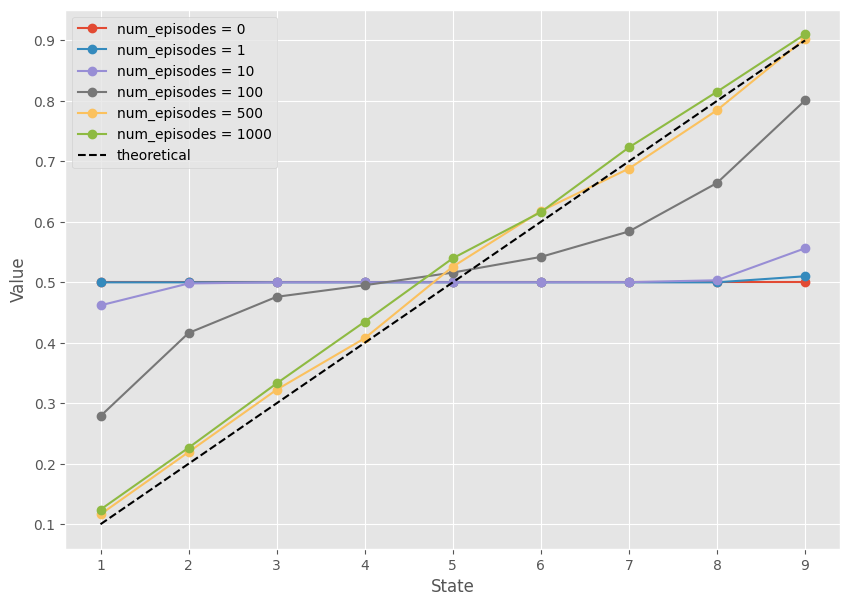

In [26]:
for num_episodes in [0, 1, 10, 100, 500, 1000]:
    print('working on {0}'.format(num_episodes))
    v_func = init_v_func(NUM_ALL_STATES)
    for i in range(num_episodes):
        v_func = run_a_episode(v_func, alpha=0.02, n_step=1)

    # v_func[1:-1] no need to plot value of EXIT_STATES
    plt.plot(range(1, NUM_STATES + 1), v_func[1:-1], 'o-', lw=1.5,
             label='num_episodes = {0}'.format(num_episodes))

# plot theorectical line
plt.plot(range(1, NUM_STATES + 1), V_TRUE, '--', color='black',
         label='theoretical')
plt.legend(loc='best')
plt.xlabel('State')
plt.ylabel('Value')
# plt.xlim(0, NUM_STATES)
# plt.ylim(0, 1)

1. 500 is enough already to converge
1. Not sure where the `VisibleDeprecationWarning` is from in Python, do you know?

## See how mse changes along number of episodes

working on 0.01


working on 0.05
working on 0.1
working on 0.2
working on 0.5


(-0.01, 0.06952962523111744)

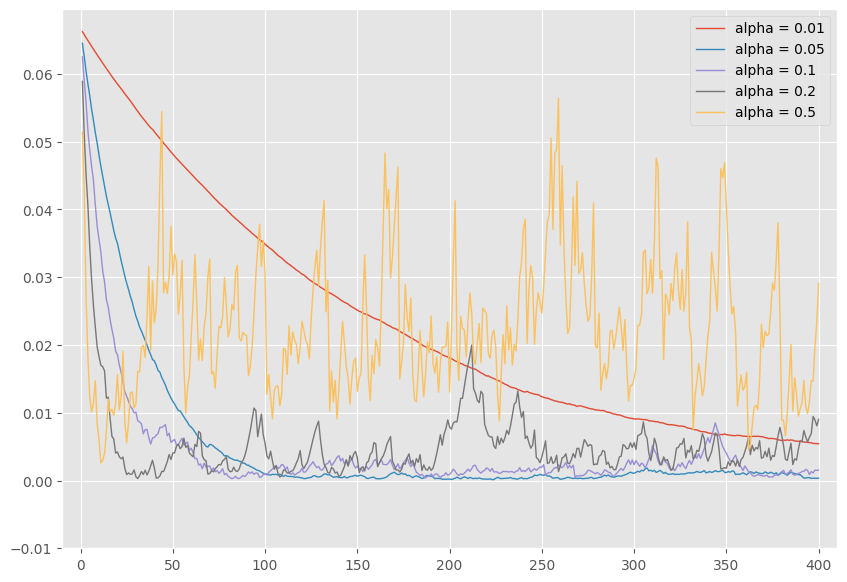

In [27]:
num_episodes = 400
for alpha in [0.01, 0.05, 0.1, 0.2, 0.5]:
    print('working on {0}'.format(alpha))
    # The value of EXIT_STATES should be 0
    v_func = init_v_func(NUM_ALL_STATES)
    mse = []
    for i in range(num_episodes):
        v_func = run_a_episode(v_func, alpha=alpha, n_step=1)
        mse.append(mean_squared_error(V_TRUE, v_func[1:-1]))

    plt.plot(np.arange(num_episodes) + 1, mse, lw=1,
             label='alpha = {0}'.format(alpha))

plt.legend(loc='best')
plt.xlim(-10, num_episodes + 10)
plt.ylim(-0.01, plt.ylim()[1])

Larger alpha makes it hard to converge, $\alpha=0.5$ is NO good!